In [1]:
# Step 1: Import necessary libraries
import os
import numpy as np
import pandas as pd
from sklearn.model_selection import KFold
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import InceptionV3
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Dropout, GlobalAveragePooling2D
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint


In [10]:
import os
import pandas as pd
from sklearn.model_selection import KFold
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau

# Step 2: Prepare dataset paths and labels
data_dir = "/kaggle/input/newdataset/Crop Diseases"  # Thay thế bằng đường dẫn tới dataset của bạn
class_dirs = [d for d in os.listdir(data_dir) if os.path.isdir(os.path.join(data_dir, d))]

# Khởi tạo danh sách đường dẫn hình ảnh và nhãn
image_files = []
labels = []

# Lặp qua các thư mục lớp và gán nhãn cho mỗi hình ảnh
for label, class_name in enumerate(class_dirs):
    class_dir = os.path.join(data_dir, class_name)
    
    # Lặp qua tất cả hình ảnh trong thư mục lớp
    for image_name in os.listdir(class_dir):
        image_files.append(os.path.join(class_dir, image_name))
        labels.append(class_name)  # Sử dụng tên thư mục làm nhãn (tên lớp)

# Tạo DataFrame để tổ chức các đường dẫn hình ảnh và nhãn
data = pd.DataFrame({"image": image_files, "label": labels})

# In ra thông tin về dataset
print(f"Tổng số hình ảnh: {len(image_files)}")
print(f"Các lớp: {class_dirs}")

# Step 3: Set up K-Fold Cross Validation
n_splits = 20  # Số lượng fold
kf = KFold(n_splits=n_splits, shuffle=True, random_state=42)

# Khởi tạo ImageDataGenerator cho dữ liệu huấn luyện
datagen = ImageDataGenerator(rescale=1.0 / 255)

# Lưu kết quả mỗi fold
fold_results = []

# Step 4: Train the model for each fold
for fold, (train_idx, val_idx) in enumerate(kf.split(data)):
    print(f"\nTraining Fold {fold + 1}/{n_splits}")
    
    # Tách dữ liệu huấn luyện và validation
    train_data = data.iloc[train_idx].copy()
    val_data = data.iloc[val_idx].copy()

    # Convert labels thành dạng chuỗi
    train_data['label'] = train_data['label'].astype(str)
    val_data['label'] = val_data['label'].astype(str)

    # Tạo generators cho huấn luyện và validation
    train_generator = datagen.flow_from_dataframe(
        dataframe=train_data,
        x_col="image",
        y_col="label",
        target_size=(256, 256),
        batch_size=128,
        class_mode="categorical"
    )
    val_generator = datagen.flow_from_dataframe(
        dataframe=val_data,
        x_col="image",
        y_col="label",
          target_size=(256, 256),
        batch_size=128,
        class_mode="categorical"
    )
    
    # Lấy chỉ mục lớp từ generator (class to index mapping)
    class_indices = train_generator.class_indices


Tổng số hình ảnh: 23100
Các lớp: ['Corn___Northern_Leaf_Blight', 'Wheat___Yellow_Rust', 'Sugarcane_Bacterial Blight', 'Potato___Healthy', 'Rice___Neck_Blast', 'Corn___Healthy', 'Wheat___Brown_Rust', 'Corn___Gray_Leaf_Spot', 'Rice___Brown_Spot', 'Sugarcane_Red Rot', 'Sugarcane_Healthy', 'Wheat___Healthy', 'Rice___Leaf_Blast', 'Potato___Late_Blight', 'Rice___Healthy', 'Corn___Common_Rust', 'Potato___Early_Blight']

Training Fold 1/20
Found 21945 validated image filenames belonging to 17 classes.
Found 1155 validated image filenames belonging to 17 classes.

Training Fold 2/20
Found 21945 validated image filenames belonging to 17 classes.
Found 1155 validated image filenames belonging to 17 classes.

Training Fold 3/20
Found 21945 validated image filenames belonging to 17 classes.
Found 1155 validated image filenames belonging to 17 classes.

Training Fold 4/20
Found 21945 validated image filenames belonging to 17 classes.
Found 1155 validated image filenames belonging to 17 classes.

Tra

In [ ]:
 # Step 5: Build the model
base_model = InceptionV3(weights="imagenet", include_top=False)
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dropout(0.7)(x)
x = Dense(1024, activation="relu")(x)
predictions = Dense(17, activation="softmax")(x)
model = Model(inputs=base_model.input, outputs=predictions)

    # Freeze base model layers
for layer in base_model.layers:
    layer.trainable = False

    # Compile the model
model.compile(
    optimizer="adam",
    loss="categorical_crossentropy",
    metrics=["accuracy"]
)

In [ ]:
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.optimizers import Adam

# Cố định learning rate
fixed_lr = 1e-4  # Bạn có thể thay đổi giá trị này
optimizer = Adam(learning_rate=fixed_lr)

# Compile mô hình với learning rate cố định
model.compile(
    optimizer=optimizer,
    loss="categorical_crossentropy",
    metrics=["accuracy"]
)

# Step 6: Set up callbacks
checkpoint_path = f"model_fold_{fold + 1}_epoch_{{epoch:02d}}.keras"
checkpoint = ModelCheckpoint(
    checkpoint_path,
    monitor="val_accuracy",
    verbose=1,
    save_best_only=True,
    mode="max"
)

# Không sử dụng ReduceLROnPlateau nếu muốn cố định learning rate
# early_stop = EarlyStopping(monitor="val_loss", patience=5, restore_best_weights=True)

# Train the model
history = model.fit(
    train_generator,
    validation_data=val_generator,
    epochs=200,
    callbacks=[checkpoint]  # Không thêm ReduceLROnPlateau
)

# Save the best model for the current fold
model_save_path = f"final_model_fold_{fold + 1}.keras"
model.save(model_save_path)
print(f"Model for Fold {fold + 1} saved at {model_save_path}")

# Save fold results
fold_results.append({
    "fold": fold + 1,
    "accuracy": history.history["val_accuracy"][-1],
    "loss": history.history["val_loss"][-1]
})


In [ ]:
# Step 7: Calculate average results across folds
avg_accuracy = np.mean([result["accuracy"] for result in fold_results])
avg_loss = np.mean([result["loss"] for result in fold_results])

print(f"\nAverage Accuracy across folds: {avg_accuracy}")
print(f"Average Loss across folds: {avg_loss}")

In [ ]:
import tensorflow as tf
# Unfreeze all layers in the base model
for layer in base_model.layers:
    layer.trainable = True

# Compile the model again with a lower learning rate
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-5),  # Reduce learning rate
    loss="categorical_crossentropy",
    metrics=["accuracy"]
)

# Fine-tune the model
history_fine_tune = model.fit(
    train_generator,
    validation_data=val_generator,
    epochs=100,  # Fine-tuning typically requires fewer epochs
    callbacks=[ reduce_lr, checkpoint]
)
model.save("final_tuning.keras")

/opt/conda/lib/python3.10/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


10/10 ━━━━━━━━━━━━━━━━━━━━ 45s 2s/step


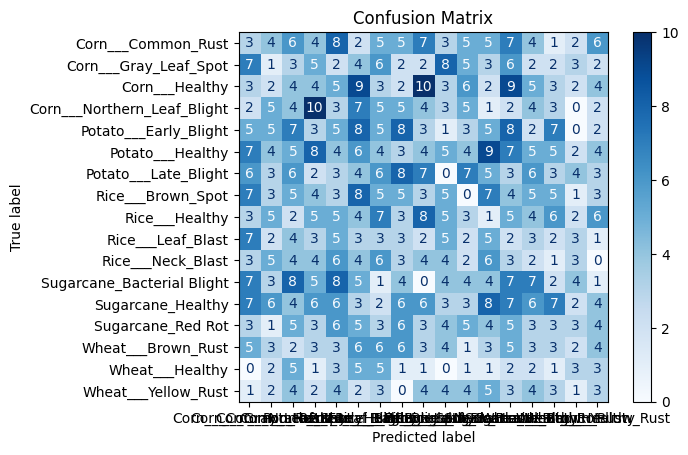

In [11]:
import numpy as np
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
from tensorflow.keras.models import load_model

# Tải mô hình đã huấn luyện
model = load_model("/kaggle/input/newmodeltrained/final_model_fold_20.keras")
# Dự đoán từ mô hình trên val_generator
y_pred_probs = model.predict(val_generator)  # Dự đoán xác suất
y_pred = np.argmax(y_pred_probs, axis=1)  # Chọn lớp có xác suất cao nhất

# Nhãn thực tế từ val_generator
y_true = val_generator.classes  # Nhãn thực tế từ generator

# Tạo confusion matrix
cm = confusion_matrix(y_true, y_pred)

# Hiển thị ma trận nhầm lẫn
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=val_generator.class_indices.keys())
disp.plot(cmap=plt.cm.Blues)
plt.title("Confusion Matrix")
plt.show()


In [ ]:
import requests
%cd /kaggle/working
# URL của hình ảnh
image_url = "https://www.ndsu.edu/agriculture/sites/default/files/2022-05/Figure_3.jpg"

# Tên tệp lưu trữhttps://www.ndsu.edu/agriculture/sites/default/files/2022-05/Figure_3.jpg
image_name = "downloaded_image.jpg"

# Tải hình ảnh
response = requests.get(image_url)

# Lưu hình ảnh vào file
if response.status_code == 200:
    with open(image_name, "wb") as f:
        f.write(response.content)
    print(f"Hình ảnh đã được tải về và lưu thành: {image_name}")
else:
    print(f"Không thể tải hình ảnh. Mã lỗi: {response.status_code}")

In [ ]:
from tensorflow.keras.models import load_model

# Tải mô hình đã huấn luyện
model = load_model("/kaggle/working/final_tuning.keras")

# Lấy tầng cuối cùng của mô hình
output_layer = model.layers[-1]

# Lấy số lượng lớp (số units trong lớp Dense cuối cùng)
num_classes = output_layer.units
print(f"Number of classes in the model: {num_classes}")

from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Khởi tạo đối tượng ImageDataGenerator
datagen = ImageDataGenerator(rescale=1.0 / 255)  # Rescale pixel từ 0-255 về 0-1
train_generator = datagen.flow_from_directory(
    "/kaggle/input/top-agriculture-crop-disease/Crop Diseases",  # Thư mục chứa dữ liệu
    target_size=(256, 256 b nbbbvbvbbv),  # Kích thước ảnh
    batch_size=128,           # Kích thước batch
    class_mode="categorical"  # Dữ liệu là các lớp phân loại
)

# In ánh xạ class indices
print("Class indices mapping:")
print(train_generator.class_indices)

# Đảo ngược ánh xạ để lấy danh sách nhãn
class_labels = {v: k for k, v in train_generator.class_indices.items()}
print("Class labels:")
print(class_labels)


In [ ]:
import matplotlib.pyplot as plt

# Plot training results for the current fold
def plot_training_history(history, fold):
    # Extract metrics
    accuracy = history.history['accuracy']
    val_accuracy = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']

    # Create a figure
    plt.figure(figsize=(12, 6))

    # Plot accuracy
    plt.subplot(1, 2, 1)
    plt.plot(accuracy, label='Training Accuracy')
    plt.plot(val_accuracy, label='Validation Accuracy')
    plt.title(f'Accuracy for Fold {fold}')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()

    # Plot loss
    plt.subplot(1, 2, 2)
    plt.plot(loss, label='Training Loss')
    plt.plot(val_loss, label='Validation Loss')
    plt.title(f'Loss for Fold {fold}')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

    # Save the plotmodel = load_model("/kaggle/working/final_tuning.keras")
    plot_path = f"training_plot_fold_{fold}.png"
    plt.savefig(plot_path)
    plt.show()
    print(f"Training plot for Fold {fold} saved at {plot_path}")

# Call the function after training each fold
plot_training_history(history, fold + 1)


In [ ]:
# Plot combined results across folds
def plot_combined_results(fold_results):
    folds = [result['fold'] for result in fold_results]
    accuracies = [result['accuracy'] for result in fold_results]
    losses = [result['loss'] for result in fold_results]

    # Create a figure
    plt.figure(figsize=(8, 6))

    # Plot accuracy and loss for each fold
    plt.plot(folds, accuracies, label='Validation Accuracy', marker='o')
    plt.plot(folds, losses, label='Validation Loss', marker='o')
    plt.title('Validation Metrics Across Folds')
    plt.xlabel('Fold')
    plt.ylabel('Metrics')
    plt.xticks(folds)
    plt.legend()

    # Save the plot
    combined_plot_path = "combined_training_results.png"
    plt.savefig(combined_plot_path)
    plt.show()
    print(f"Combined training plot saved at {combined_plot_path}")

# Call the function after all folds are trained
plot_combined_results(fold_results)


In [ ]:
import json

# Giả sử model là mô hình của bạn sau khi huấn luyện
class_indices = model.class_indices

# Lưu ánh xạ lớp vào một tệp JSON
with open('class_indices.json', 'w') as f:
    json.dump(class_indices, f)


In [ ]:
import os
import numpy as np
from keras.preprocessing import image
from keras.models import load_model

# Load the pre-trained model
model = load_model('/kaggle/working/final_model_fold_10.keras')

# Get the class labels from the model's class_indices
class_labels = {0: 'Corn___Common_Rust', 1: 'Corn___Gray_Leaf_Spot', 2: 'Corn___Healthy', 3: 'Corn___Northern_Leaf_Blight', 4: 'Potato___Early_Blight', 5: 'Potato___Healthy', 6: 'Potato___Late_Blight', 7: 'Rice___Brown_Spot', 8: 'Rice___Healthy', 9: 'Rice___Leaf_Blast', 10: 'Rice___Neck_Blast', 11: 'Sugarcane_Bacterial Blight', 12: 'Sugarcane_Healthy', 13: 'Sugarcane_Red Rot', 14: 'Wheat___Brown_Rust', 15: 'Wheat___Healthy', 16: 'Wheat___Yellow_Rust'}

# Function to detect images in a folder
def detect_images_in_folder(folder_path):
    # Get the list of image files in the folder
    image_files = [f for f in os.listdir(folder_path) if f.lower().endswith(('.png', '.jpg', '.jpeg'))]
    
    # Iterate through the image files
    for image_file in image_files:
        image_path = os.path.join(folder_path, image_file)
        
        # Load and preprocess the image
        img = image.load_img(image_path, target_size=(224, 224))  # Change target size if needed
        img_array = image.img_to_array(img)
        img_array = np.expand_dims(img_array, axis=0)  # Add batch dimension
        img_array = img_array / 255.0  # Normalize if needed (depending on your model's training)

        # Predict the class
        predictions = model.predict(img_array)
        class_index = np.argmax(predictions, axis=1)[0]  # Get the index of the class with the highest probability
        
        # Map the index to class label
        predicted_label = class_labels.get(class_index, 'Unknown')

        print(f"Image: {image_file} - Predicted label: {predicted_label}")

# Path to the folder containing images
folder_path = '/kaggle/input/top-agriculture-crop-disease/Crop Diseases/Corn___Healthy'
detect_images_in_folder(folder_path)


In [1]:
import os
import numpy as np
import tensorflow as tf
# Load the pre-trained model
model = tf.keras.models.load_model('/kaggle/input/newmodeltrained/final_model_fold_20.keras')
# Get the class labels from the model's class_indices
class_labels = {0: 'Corn___Common_Rust', 1: 'Corn___Gray_Leaf_Spot', 2: 'Corn___Healthy', 3: 'Corn___Northern_Leaf_Blight', 4: 'Potato___Early_Blight', 5: 'Potato___Healthy', 6: 'Potato___Late_Blight', 7: 'Rice___Brown_Spot', 8: 'Rice___Healthy', 9: 'Rice___Leaf_Blast', 10: 'Rice___Neck_Blast', 11: 'Sugarcane_Bacterial Blight', 12: 'Sugarcane_Healthy', 13: 'Sugarcane_Red Rot', 14: 'Wheat___Brown_Rust', 15: 'Wheat___Healthy', 16: 'Wheat___Yellow_Rust'}

In [2]:
from lime import lime_image
explainer = lime_image.LimeImageExplainer()

In [4]:
import os
import matplotlib.pyplot as plt
from keras.preprocessing import image
import numpy as np
import tensorflow as tf
img_path = os.path.join('data', '/kaggle/input/top-agriculture-crop-disease/Crop Diseases/Rice___Neck_Blast/IMG20201108163519_00.jpg')
# Load and preprocess the image
img = image.load_img(img_path, target_size=(224, 224))  # InceptionV3 typically expects (224, 224) images
img_array = image.img_to_array(img)  # Convert the image to a numpy array
img_array = np.expand_dims(img_array, axis=0)  # Add batch dimension
img_array /= 255.0  # Normalize the image if required by your model
from PIL import Image
import numpy as np

# Now you can pass the loaded image to the explainer
explanation = explainer.explain_instance(img, model.predict, top_labels=5, hide_color=0, num_samples=1000)


AttributeError: 'Image' object has no attribute 'shape'

In [ ]:
import matplotlib.pyplot as plt
from skimage.segmentation import mark_boundaries
temp, mask = explanation.get_image_and_mask(explanation.top_labels[0], positive_only=True, num_features=5, hide_rest=True)
plt.imshow(mark_boundaries(temp / 255 , mask))
#Select the same class explained on the figures above.
ind =  explanation.top_labels[0]

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# Assuming explanation.local_exp and explanation.segments are already defined
dict_heatmap = dict(explanation.local_exp[ind])
heatmap = np.vectorize(dict_heatmap.get)(explanation.segments)

# Plot the heatmap with a symmetrical colorbar
plt.imshow(heatmap, cmap='RdBu', vmin=-heatmap.max(), vmax=heatmap.max())
plt.colorbar()
plt.title('Superpixel Explanation Heatmap')
plt.axis('off')  # Hide the axis for better visualization
plt.show()


In [ ]:
def transform_img_fn(path_list):
    out = []
    for img_path in path_list:
        img = image.load_img(img_path, target_size=(299, 299))
        x = image.img_to_array(img)
        x = np.expand_dims(x, axis=0)
        out.append(x)
    return np.vstack(out)

/opt/conda/lib/python3.10/pty.py:89: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  pid, fd = os.forkpty()


1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step
Dự đoán lớp: Rice___Neck_Blast


  0%|          | 0/1000 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━

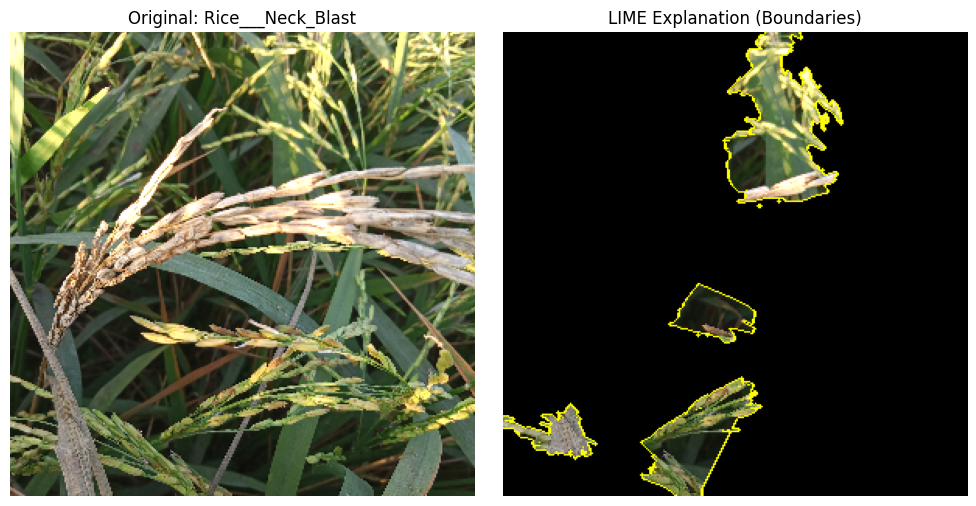

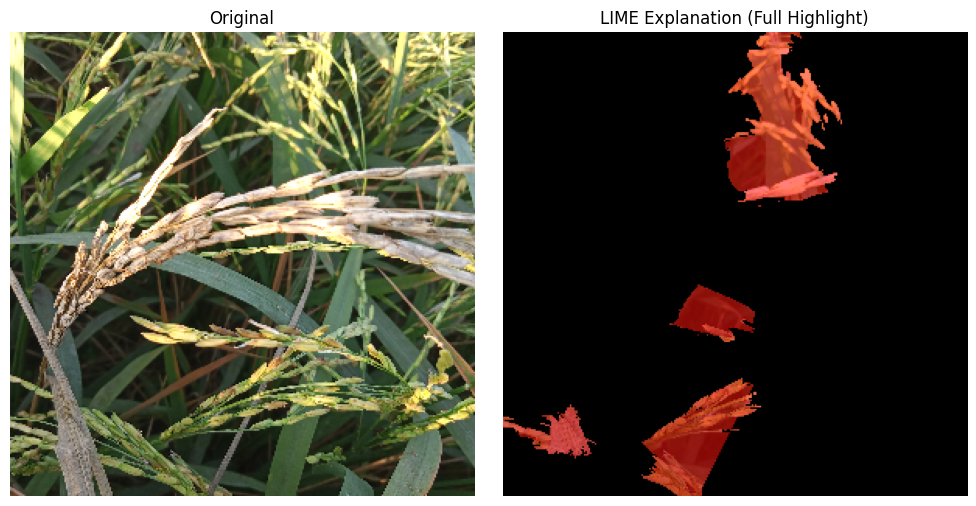

In [9]:
!pip install lime

import os
import numpy as np
import tensorflow as tf
import cv2
import matplotlib.pyplot as plt
from lime import lime_image
from skimage.segmentation import mark_boundaries

# Tải model đã huấn luyện
model_path = '/kaggle/input/newmodeltrained/final_model_fold_20.keras'
model = tf.keras.models.load_model(model_path)

# Danh sách class labels
class_labels = {
    0: 'Corn___Common_Rust', 
    1: 'Corn___Gray_Leaf_Spot', 
    2: 'Corn___Healthy', 
    3: 'Corn___Northern_Leaf_Blight', 
    4: 'Potato___Early_Blight', 
    5: 'Potato___Healthy', 
    6: 'Potato___Late_Blight', 
    7: 'Rice___Brown_Spot', 
    8: 'Rice___Healthy', 
    9: 'Rice___Leaf_Blast', 
    10: 'Rice___Neck_Blast', 
    11: 'Sugarcane_Bacterial Blight', 
    12: 'Sugarcane_Healthy', 
    13: 'Sugarcane_Red Rot', 
    14: 'Wheat___Brown_Rust', 
    15: 'Wheat___Healthy', 
    16: 'Wheat___Yellow_Rust'
}

# Đường dẫn ảnh
img_path = '/kaggle/input/top-agriculture-crop-disease/Crop Diseases/Rice___Neck_Blast/IMG20201108163519_00.jpg'

# Đọc và tiền xử lý ảnh
# Nếu sử dụng InceptionV3, size (299, 299)
img = cv2.imread(img_path)
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
img_resized = cv2.resize(img, (299, 299))
img_preprocessed = tf.keras.applications.inception_v3.preprocess_input(img_resized.astype(np.float32))
img_batch = np.expand_dims(img_preprocessed, axis=0)

# Dự đoán
pred_probs = model.predict(img_batch)
pred_class = np.argmax(pred_probs)
print("Dự đoán lớp:", class_labels[pred_class])

# Hàm dự đoán cho LIME
def predict_proba(images):
    imgs_preprocessed = []
    for im in images:
        # Resize nếu cần thiết (trong trường hợp LIME perturbation khác kích thước)
        if im.shape[:2] != (299, 299):
            im = cv2.resize(im, (299, 299))
        im_p = tf.keras.applications.inception_v3.preprocess_input(im.astype(np.float32))
        imgs_preprocessed.append(im_p)
    imgs_preprocessed = np.array(imgs_preprocessed)
    return model.predict(imgs_preprocessed)

# Tạo LIME explainer
explainer = lime_image.LimeImageExplainer(verbose=False)

# Giải thích ảnh
explanation = explainer.explain_instance(
    img_resized, 
    predict_proba, 
    top_labels=5, 
    hide_color=0, 
    num_samples=1000
)

# Lấy mask và ảnh
# positive_only=True: chỉ hiển thị những vùng làm tăng xác suất cho lớp được chọn
# hide_rest=True: các vùng không quan trọng bị làm đen
temp, mask = explanation.get_image_and_mask(
    explanation.top_labels[0], 
    positive_only=True, 
    num_features=5, 
    hide_rest=True
)

# Hiển thị kết quả với mark_boundaries (mặc định viền màu vàng)
plt.figure(figsize=(10, 5))

plt.subplot(1, 2, 1)
plt.title(f"Original: {class_labels[pred_class]}")
plt.imshow(img_resized)
plt.axis('off')

plt.subplot(1, 2, 2)
plt.title("LIME Explanation (Boundaries)")
# Chia 255 để đưa ảnh về range [0,1] cho mark_boundaries
plt.imshow(mark_boundaries((temp / 255.0).astype(np.float32), mask))
plt.axis('off')

plt.tight_layout()
plt.show()

# Nếu muốn tô màu toàn bộ vùng mask với màu tùy chọn:
import numpy as np

highlight_color = np.array([255, 0, 0], dtype=np.uint8)  # Màu đỏ
alpha = 0.5  # độ trong suốt

overlay = temp.copy().astype(np.float32)
overlay[mask == 1] = (1 - alpha)*overlay[mask == 1] + alpha*highlight_color

plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.title("Original")
plt.imshow(img_resized)
plt.axis('off')

plt.subplot(1, 2, 2)
plt.title("LIME Explanation (Full Highlight)")
plt.imshow(overlay.astype(np.uint8))
plt.axis('off')

plt.tight_layout()
plt.show()
